In [51]:
# This script can be configured to run either a Hortonian or Dunne flow example
# using ParFlow. It is configured to run using the orthogonal grid
# using a PFSOLID file and to output total runoff.

# R. Maxwell, originally developed in 2009, updated PF Short Course 2019, updated to Python and Jupyter 2022
# reedmaxwell@princeton.edu

from parflow import Run
from parflow.tools.fs import get_absolute_path, cp, rm, mkdir, exists
import numpy as np
from set_demo_defaults import *

# set up directories
base_dir = get_absolute_path(".")
mkdir('dunne_over')
run_name = "Dunne"
dir_name = f"./dunne_over"

def run_off_code(alpha_vG):
    Dunne = Run(run_name)

    Dunne.FileVersion = 4
    
    # -----------------------------------------------------------------------------
    # Process Topology
    # -----------------------------------------------------------------------------
    Dunne.Process.Topology.P = 1
    Dunne.Process.Topology.Q = 1
    Dunne.Process.Topology.R = 1
    
    #---------------------------------------------------------
    # Computational Grid
    #---------------------------------------------------------
    Dunne.ComputationalGrid.Lower.X = 0.0
    Dunne.ComputationalGrid.Lower.Y = 0.0
    Dunne.ComputationalGrid.Lower.Z = 0.0
    
    Dunne.ComputationalGrid.NX = 20
    Dunne.ComputationalGrid.NY = 1
    Dunne.ComputationalGrid.NZ = 300
    
    Dunne.ComputationalGrid.DX = 5.0
    Dunne.ComputationalGrid.DY = 1.0
    Dunne.ComputationalGrid.DZ = .05
    
    #---------------------------------------------------------
    # Domain Geometry
    #---------------------------------------------------------
    Dunne.GeomInput.Names = 'solidinput1'
    
    Dunne.GeomInput.solidinput1.InputType = 'SolidFile'
    Dunne.GeomInput.solidinput1.GeomNames = 'domain'
    Dunne.GeomInput.solidinput1.FileName = '../domain.pfsol'
    
    Dunne.Geom.domain.Patches = 'z_upper x_lower y_lower x_upper y_upper z_lower'
    
    #-----------------------------------------------------------------------------
    # Perm
    #-----------------------------------------------------------------------------
    
    Dunne.Geom.Perm.Names = 'domain'
    
    # Values in m/hour
    
    Dunne.Geom.domain.Perm.Type = 'Constant'
    Dunne.Geom.domain.Perm.Value = 1.
    Dunne.Geom.domain.Perm.Value = 0.001
    
    Dunne.Perm.TensorType = 'TensorByGeom'
    
    Dunne.Geom.Perm.TensorByGeom.Names = 'domain'
    
    Dunne.Geom.domain.Perm.TensorValX = 1.0
    Dunne.Geom.domain.Perm.TensorValY = 1.0
    Dunne.Geom.domain.Perm.TensorValZ = 1.0
    
    #-----------------------------------------------------------------------------
    # Specific Storage
    #-----------------------------------------------------------------------------
    
    Dunne.SpecificStorage.Type = 'Constant'
    Dunne.SpecificStorage.GeomNames = 'domain'
    Dunne.Geom.domain.SpecificStorage.Value = 1.0e-5
    
    #-----------------------------------------------------------------------------
    # Phases
    #-----------------------------------------------------------------------------
    
    Dunne.Phase.Names = 'water'
    
    Dunne.Phase.water.Density.Type = 'Constant'
    Dunne.Phase.water.Density.Value = 1.0
    
    Dunne.Phase.water.Viscosity.Type = 'Constant'
    Dunne.Phase.water.Viscosity.Value = 1.0
    
    #-----------------------------------------------------------------------------
    # Contaminants
    #-----------------------------------------------------------------------------
    
    Dunne.Contaminants.Names = ''
    
    #-----------------------------------------------------------------------------
    # Retardation
    #-----------------------------------------------------------------------------
    
    Dunne.Geom.Retardation.GeomNames = ''
    
    #-----------------------------------------------------------------------------
    # Gravity
    #-----------------------------------------------------------------------------
    
    Dunne.Gravity = 1.0
    
    #-----------------------------------------------------------------------------
    # Setup timing info
    #-----------------------------------------------------------------------------
    
    # run for 3 hours @ 3min timesteps
    #
    Dunne.TimingInfo.BaseUnit = 0.01
    Dunne.TimingInfo.StartCount = 0
    Dunne.TimingInfo.StartTime = 0.0
    Dunne.TimingInfo.StopTime = 1.0
    Dunne.TimingInfo.DumpInterval = -1
    Dunne.TimeStep.Type = 'Constant'
    Dunne.TimeStep.Value = 0.01
    
    #-----------------------------------------------------------------------------
    # Porosity
    #-----------------------------------------------------------------------------
    
    Dunne.Geom.Porosity.GeomNames = 'domain'
    Dunne.Geom.domain.Porosity.Type = 'Constant'
    Dunne.Geom.domain.Porosity.Value = 0.01
    
    #-----------------------------------------------------------------------------
    # Domain
    #-----------------------------------------------------------------------------
    
    Dunne.Domain.GeomName = 'domain'
    
    #-----------------------------------------------------------------------------
    # Relative Permeability
    #-----------------------------------------------------------------------------
    
    Dunne.Phase.RelPerm.Type = 'VanGenuchten'
    Dunne.Phase.RelPerm.GeomNames = 'domain'
    
    Dunne.Geom.domain.RelPerm.Alpha = alpha_vG
    Dunne.Geom.domain.RelPerm.N = 2.
    
    #---------------------------------------------------------
    # Saturation
    #---------------------------------------------------------
    
    Dunne.Phase.Saturation.Type = 'VanGenuchten'
    Dunne.Phase.Saturation.GeomNames = 'domain'
    
    Dunne.Geom.domain.Saturation.Alpha = alpha_vG
    Dunne.Geom.domain.Saturation.N = 2.
    Dunne.Geom.domain.Saturation.SRes = 0.2
    Dunne.Geom.domain.Saturation.SSat = 1.0
    
    #-----------------------------------------------------------------------------
    # Wells
    #-----------------------------------------------------------------------------
    Dunne.Wells.Names = ''
    
    #-----------------------------------------------------------------------------
    # Time Cycles
    #-----------------------------------------------------------------------------
    Dunne.Cycle.Names = 'constant rainrec'
    Dunne.Cycle.constant.Names = 'alltime'
    Dunne.Cycle.constant.alltime.Length = 1
    Dunne.Cycle.constant.Repeat = -1
    
    # rainfall and recession time periods are defined here
    # rain for 3 hours, recession for 2 hours (change to rain for a different time)
    # this is a function of the BaseUnit set above, that is each length
    # is an integer mulitplier of that value.  The BaseUnit happens to be equal
    # to our timestep but that need not be the case, it's just good practice
    
    Dunne.Cycle.rainrec.Names = 'rain rec'
    Dunne.Cycle.rainrec.rain.Length = 30
    Dunne.Cycle.rainrec.rec.Length = 70
    Dunne.Cycle.rainrec.Repeat = -1
    
    
    #-----------------------------------------------------------------------------
    # Boundary Conditions: Pressure
    #-----------------------------------------------------------------------------
    # specify patches as a list for BC's
    Dunne.BCPressure.PatchNames = 'z_upper x_lower y_lower x_upper y_upper z_lower'
    
    Dunne.Patch.x_lower.BCPressure.Type = 'FluxConst'
    Dunne.Patch.x_lower.BCPressure.Cycle = 'constant'
    Dunne.Patch.x_lower.BCPressure.alltime.Value = 0.0
    
    Dunne.Patch.y_lower.BCPressure.Type = 'FluxConst'
    Dunne.Patch.y_lower.BCPressure.Cycle = 'constant'
    Dunne.Patch.y_lower.BCPressure.alltime.Value = 0.0
    
    Dunne.Patch.z_lower.BCPressure.Type = 'FluxConst'
    Dunne.Patch.z_lower.BCPressure.Cycle = 'constant'
    Dunne.Patch.z_lower.BCPressure.alltime.Value = 0.0
    
    Dunne.Patch.x_upper.BCPressure.Type = 'FluxConst'
    Dunne.Patch.x_upper.BCPressure.Cycle = 'constant'
    Dunne.Patch.x_upper.BCPressure.alltime.Value = 0.0
    
    Dunne.Patch.y_upper.BCPressure.Type = 'FluxConst'
    Dunne.Patch.y_upper.BCPressure.Cycle = 'constant'
    Dunne.Patch.y_upper.BCPressure.alltime.Value = 0.0
    
    ## overland flow boundary condition with very heavy rainfall then recession
    Dunne.Patch.z_upper.BCPressure.Type = 'OverlandFlow'
    Dunne.Patch.z_upper.BCPressure.Cycle = 'rainrec'
    Dunne.Patch.z_upper.BCPressure.rain.Value = -0.02
    Dunne.Patch.z_upper.BCPressure.rec.Value = 0.00
    
    #---------------------------------------------------------
    # Topo slopes in x-direction
    #---------------------------------------------------------
    
    Dunne.TopoSlopesX.Type = 'Constant'
    Dunne.TopoSlopesX.GeomNames = 'domain'
    Dunne.TopoSlopesX.Geom.domain.Value = 0.05
    
    #---------------------------------------------------------
    # Topo slopes in y-direction
    #---------------------------------------------------------
    
    Dunne.TopoSlopesY.Type = 'Constant'
    Dunne.TopoSlopesY.GeomNames = 'domain'
    Dunne.TopoSlopesY.Geom.domain.Value = 0.00
    
    #---------------------------------------------------------
    # Mannings coefficient
    #---------------------------------------------------------
    
    Dunne.Mannings.Type = 'Constant'
    Dunne.Mannings.GeomNames = 'domain'
    Dunne.Mannings.Geom.domain.Value = 1.e-5
    
    #-----------------------------------------------------------------------------
    # Phase sources:
    #-----------------------------------------------------------------------------
    
    Dunne.PhaseSources.water.Type = 'Constant'
    Dunne.PhaseSources.water.GeomNames = 'domain'
    Dunne.PhaseSources.water.Geom.domain.Value = 0.0
    
    #-----------------------------------------------------------------------------
    # Exact solution specification for error calculations
    #-----------------------------------------------------------------------------
    
    Dunne.KnownSolution = 'NoKnownSolution'
    
    #-----------------------------------------------------------------------------
    # Set solver parameters
    #-----------------------------------------------------------------------------
    
    Dunne.Solver = 'Richards'
    Dunne.Solver.MaxIter = 2500
    
    Dunne.Solver.Nonlinear.MaxIter = 300
    Dunne.Solver.Nonlinear.ResidualTol = 1e-6
    Dunne.Solver.Nonlinear.EtaChoice = 'Walker1'
    Dunne.Solver.Nonlinear.EtaValue = 0.001
    Dunne.Solver.Nonlinear.UseJacobian = False
    #Dunne.Solver.Nonlinear.UseJacobian = True
    Dunne.Solver.Nonlinear.DerivativeEpsilon = 1e-16
    Dunne.Solver.Nonlinear.StepTol = 1e-20
    Dunne.Solver.Nonlinear.Globalization = 'LineSearch'
    Dunne.Solver.Linear.KrylovDimension = 20
    Dunne.Solver.Linear.MaxRestart = 2
    
    #Dunne.Solver.Linear.Preconditioner.PCMatrixType = 'FullJacobian'
    
    Dunne.Solver.Linear.Preconditioner = 'MGSemi'
    Dunne.Solver.PrintSubsurf = False
    Dunne.Solver.Drop = 1E-20
    Dunne.Solver.AbsTol = 1E-12
    
    Dunne.Solver.PrintOverlandSum = True

    # Writing output options for ParFlow
    write_pfb = True  #only PFB output for water balance example
    #  PFB  no SILO
    Dunne.Solver.PrintSubsurf             = True
    Dunne.Solver.PrintSubsurfData         = write_pfb
    Dunne.Solver.PrintPressure            = write_pfb
    Dunne.Solver.PrintSaturation          = write_pfb
    Dunne.Solver.PrintCLM                 = write_pfb
    Dunne.Solver.PrintMask                = write_pfb
    Dunne.Solver.PrintSpecificStorage     = write_pfb
    Dunne.Solver.PrintEvapTrans           = write_pfb
    Dunne.Solver.PrintSlopes              = True
    Dunne.Solver.PrintVelocities          = True 
    
    #---------------------------------------------------------
    # Initial conditions: water pressure
    #---------------------------------------------------------
    
    # set water table to be level with the outlet of the domain
    Dunne.ICPressure.Type = 'HydroStaticPatch'
    Dunne.ICPressure.GeomNames = 'domain'
    #Dunne.Geom.domain.ICPressure.Value = 4.5
    Dunne.Geom.domain.ICPressure.Value  = 4.0
    
    Dunne.Geom.domain.ICPressure.RefGeom = 'domain'
    Dunne.Geom.domain.ICPressure.RefPatch = 'z_lower'
    
    #--------
    # Things that can be changed in the simulation to swap from Horton to Dunne flow
    #--------
    
    # increase the hydraulic conductivity
    # if the K values are in m/h and the rainfall rate is 0.02 m/h what K is needed
    # to create infiltration not overland flow? 
    #Dunne.Geom.domain.Perm.Value = ?
    
    # move the water table closer to the outlet, i.e. make it shallower
    # if the initial pressure value is in meters from the bottom of the domain
    # what value will create water table interactions?
    #Dunne.Geom.domain.ICPressure.Value = ?
    
    #-----------------------------------------------------------------------------
    # Run and Unload the ParFlow output files
    #-----------------------------------------------------------------------------
    
    # create a subdirectory to run in, change to this directory
    Dunne.run(base_dir+'/dunne_over')

### Calculate total flow from the domain
to get total flow we use Manning's equation times the height of water $h$ times the width of the outlet, times the timestep

$q [m^3] = \dfrac{\sqrt{S_0}}{n}\times h^{2/3} \times h \times \Delta t \times \Delta y$


# ==============================================================================
# ParFlow directory
#  - /home/SHARED/software/parflow/7c8e7f0
# ParFlow version
#  - 3.13.0
# Working directory
#  - /home/ms6985/ParFlow-project/Overland-flow-class/dunne_over
# ParFlow database
#  - Dunne.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully
# ==============================================================================


# ==============================================================================
# ParFlow directory
#  - /home/SHARED/software/parflow/7c8e7f0
# ParFlow version
#  - 3.13.0
# Working directory
#  - /home/ms6985/ParFlow-project/Overland-flow-class/dunne_over
# ParFlow database
#  - Dunne.pfidb
# ==============================================================================


# ==================================================

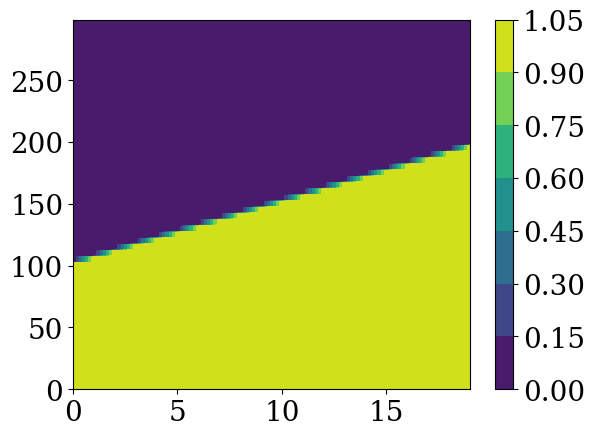

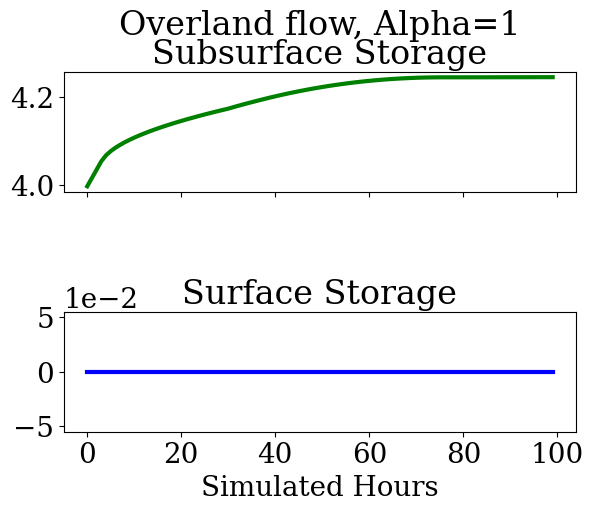

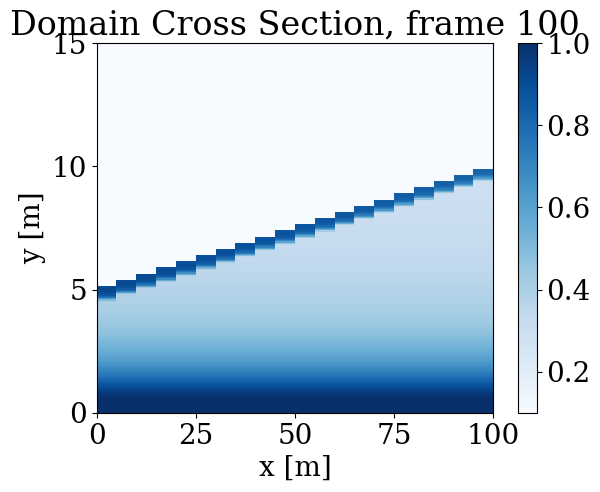

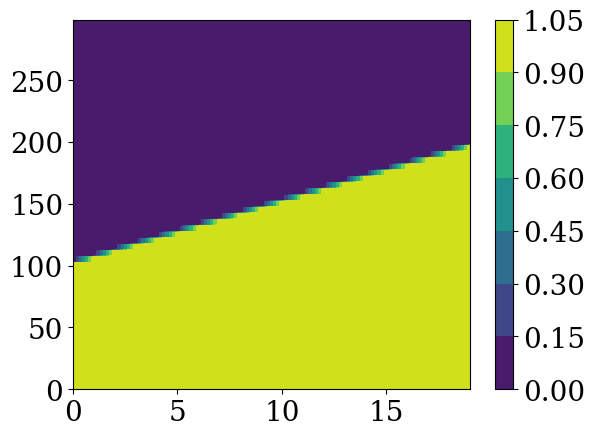

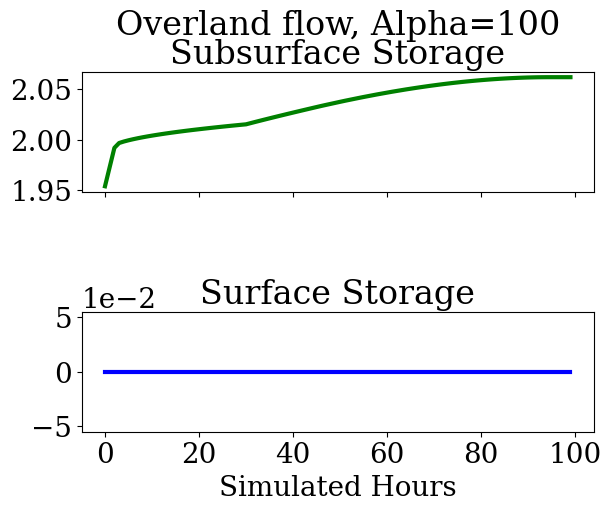

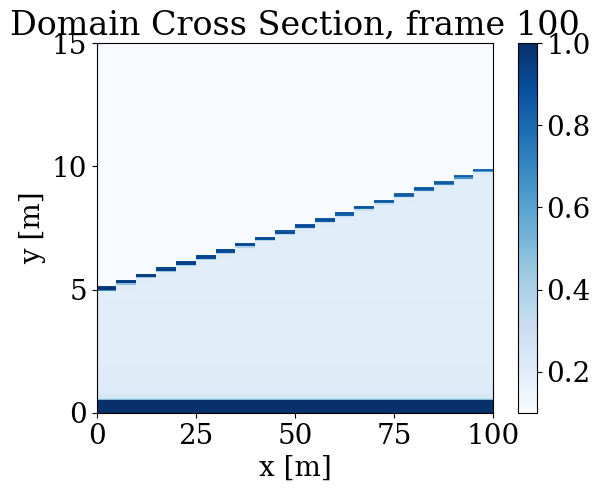

In [52]:
import parflow.tools.hydrology as hydro
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from parflow.tools.fs import get_absolute_path, cp, rm, mkdir, exists
import parflow as pf

def surface_subsurface_storage(alpha_vG,dir_name,run_name):
    run = Run.from_definition(f'{dir_name}/{run_name}.pfidb')
    data = run.data_accessor
    nt = len(data.times)
    nx = data.shape[2]
    ny = data.shape[1]
    nz = data.shape[0]
    dx = data.dx
    dy = data.dy
    dz = data.dz

    # Set up x and z to match the shape of the ParFlow grid
    x = np.arange(0.0,(nx+1)*dx,dx)
    y = np.arange(0.0,(ny+1)*dy,dy)
    z = np.zeros(nz+1)
    z[1:] = np.cumsum(dz)
    
    #print(nt,nx,ny,nz,dx,dy,dz)
    
    porosity = data.computed_porosity 
    specific_storage = data.specific_storage 
    mannings = run.Mannings.Geom.domain.Value
    
    ## remove input filenames for TopoSlopes to force the data accessor to read the output slopes
    ## this fixes a windows issue
    run.TopoSlopesX.FileName = None
    run.TopoSlopesY.FileName = None
    
    slopex = data.slope_x 
    slopey = data.slope_y 
    mask   = data.mask
    
    # formatting the mask so that values outside the domain are NA and inside the domain are 1
    nanmask=mask.copy()
    nanmask[nanmask == 0] = 'NaN'
    nanmask[nanmask > 0] = 1

    plt.figure()
    plt.contourf(data.mask[:,0,:])
    plt.colorbar()

    files = glob(dir_name+f"/{run_name}.out.satur.*.pfb")
    sat = pf.read_pfb_sequence(files)
    files = glob(dir_name+f"/{run_name}.out.press.*.pfb")
    press = pf.read_pfb_sequence(files)
    files = glob(dir_name+f"/{run_name}.out.overlandsum.*.pfb")
    overland_sum = pf.read_pfb_sequence(files)
    pressure_arrays = press
    saturation_arrays = sat

    outflow = overland_sum[:,0,0,0]  

    subsurface_storage = np.zeros(nt+1)
    surface_storage = np.zeros(nt+1)
    wtd = np.zeros((nt+1, ny, nx))
    data.time = 0
    
    for i, (pressure, saturation) in enumerate(zip(pressure_arrays, saturation_arrays)):
        subsurface_storage[i, ...] = np.sum(hydro.calculate_subsurface_storage(porosity, pressure, saturation, specific_storage, dx, dy, dz, mask = nanmask),axis=(0, 1, 2))
        # total surface storage for this time step is the summation of substorage surface across all x/y slices
        surface_storage[i, ...] = np.sum( hydro.calculate_surface_storage(pressure, dx, dy, mask = nanmask),axis=(0, 1))
        wtd[i, ...] = hydro.calculate_water_table_depth(pressure, saturation, dz)
        
        data.time = i
    
    np.savez(f'overland_flow_class_alphavG{alpha_vG}',subsurface_storage,surface_storage,outflow)  
    
    #plotting components of water balance
    fig, axs = plt.subplots(2, sharex=True)
    fig.suptitle(f'Overland flow, Alpha={alpha_vG}')
    axs[0].plot(subsurface_storage[:-1], linewidth=3, color = "green")
    axs[0].set_title("Subsurface Storage")
    axs[1].plot(surface_storage[:-1], linewidth=3, color = "blue")
    axs[1].set_title("Surface Storage")
    plt.xlabel('Simulated Hours')
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.85, 
                        wspace=0.7, 
                        hspace=1.0)
    axs[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    plt.savefig(f'overland_flow_surface_subsurface_storage_alphavG{alpha_vG}.pdf',bbox_inches='tight', dpi = 600)

    # slope and Manning's n
    mannings = 1.e-5
    slope = 0.05
    
    # set a variable for the timestep plotted in saturation cross section
    icount = 100
    
    ## Plot results
    ## three subplots
    fig, ax = plt.subplots(1)
    ax.set_title("Domain Cross Section, frame {}".format(icount))
    im = ax.pcolormesh(x, z, sat[icount,:,0,:], vmin=0.1, vmax=1.0,cmap='Blues')  
    fig.colorbar(im)
    ax.set_ylabel('y [m]')
    ax.set_xlabel('x [m]')
    plt.savefig(f'overland_flow_outflow_alphavG{alpha_vG}.pdf',bbox_inches='tight', dpi = 600)

for alpha_vG in [1,100]:
    run_off_code(alpha_vG)
    surface_subsurface_storage(alpha_vG,dir_name,run_name)

[51.10917883 50.86707318 50.627263   50.74111337 50.86856584 50.95342885
 51.01983855 51.07558034 51.12430659 51.16801791 51.20795134 51.24494026
 51.27955811 51.31220578 51.34316937 51.37265326 51.40082319 51.42781791
 51.4537618  51.4788739  51.50315288 51.52667268 51.54938598 51.5715675
 51.5930864  51.61407728 51.63458056 51.65462974 51.67447291 51.69370663
 51.7125748  51.71962596 51.72574288 51.73125688 51.7363015  51.74095319
 51.74526241 51.74926239 51.75297731 51.75642521 51.7588356  51.76028874
 51.76153152 51.76204188 51.76143701 51.76066031 51.75868472 51.75719214
 51.75532328 51.75246526 51.74924236 51.74500939 51.74155866 51.73689622
 51.73190387 51.72619161 51.72083242 51.7145387  51.70754958 51.70106175
 51.6936307  51.68581046 51.67788659 51.66960735 51.66056787 51.65179635
 51.64256074 51.63276764 51.62304898 51.61280715 51.60246536 51.59177485
 51.58100365 51.56992354 51.55831114 51.54736596 51.53546318 51.52451395
 51.51380972 51.50387337 51.49435958 51.48548797 51.

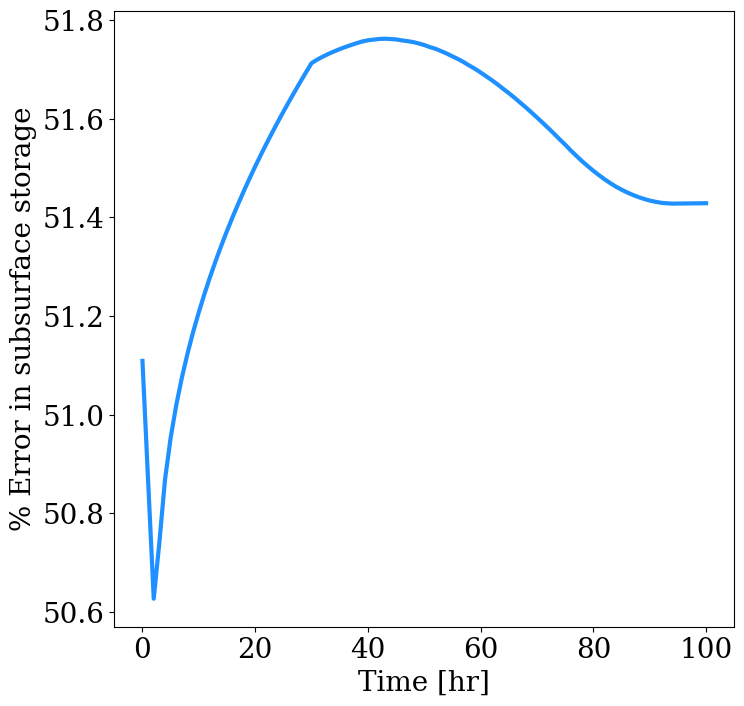

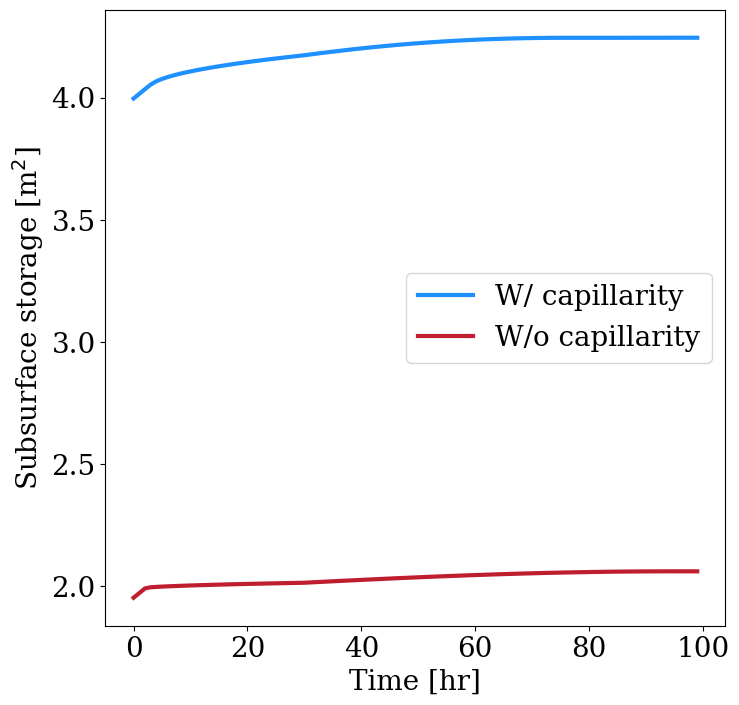

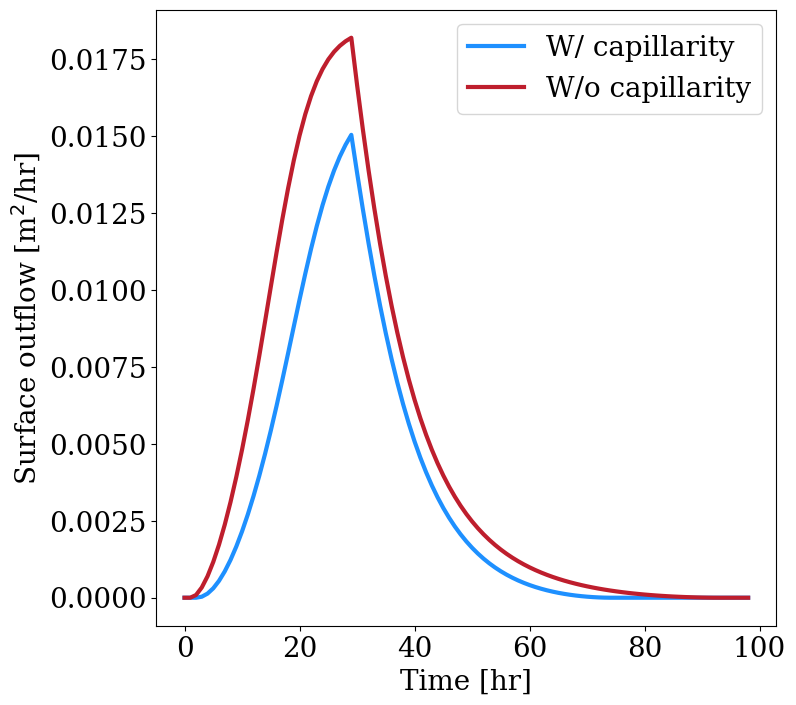

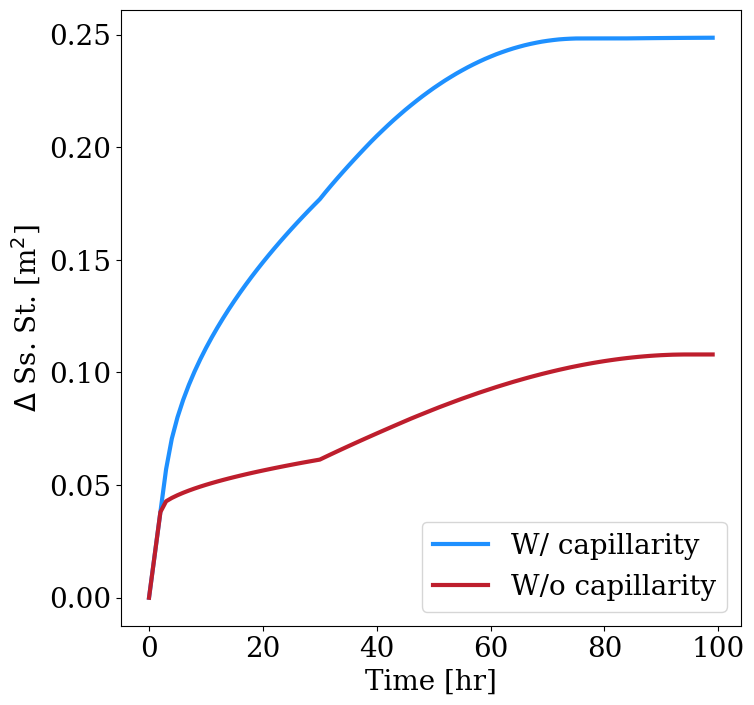

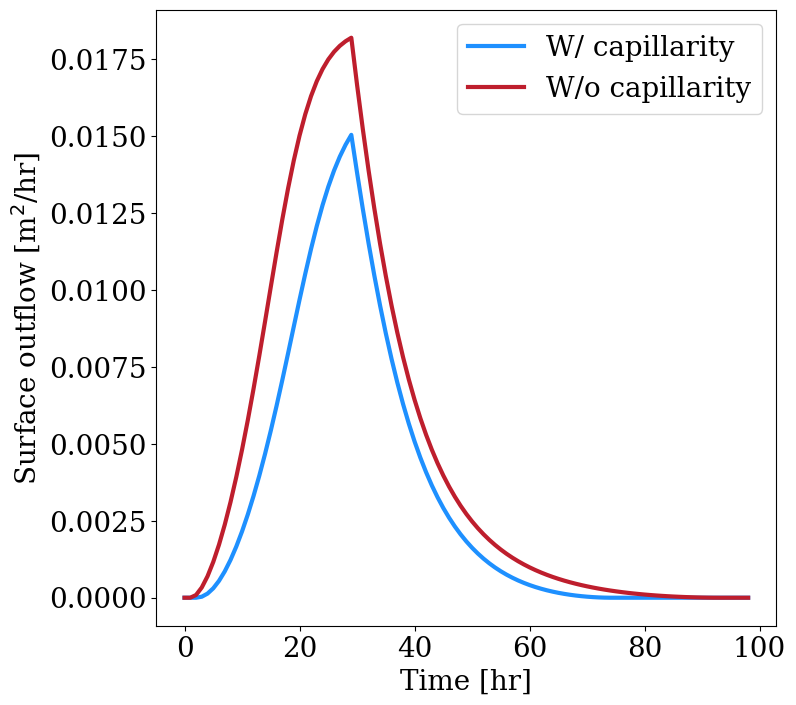

In [53]:
subsurface_storagealphavG100 = np.load(f'overland_flow_class_alphavG100.npz'); subsurf_storage100 = subsurface_storagealphavG100['arr_0']; overland100 = subsurface_storagealphavG100['arr_2'] 
subsurface_storagealphavG1 = np.load(f'overland_flow_class_alphavG1.npz'); subsurf_storage1 = subsurface_storagealphavG1['arr_0']; overland1 = subsurface_storagealphavG1['arr_2']
print((subsurf_storage1-subsurf_storage100)/subsurf_storage1*100)

plt.figure(figsize=(8,8) , dpi=100)
plt.plot((subsurf_storage1-subsurf_storage100)/subsurf_storage1*100,color=blue,linewidth=3)
plt.xlabel('Time [hr]')
plt.ylabel('% Error in subsurface storage')
plt.savefig(f'overland_flow_Error__subsurface_storage.pdf',bbox_inches='tight', dpi = 600)


plt.figure(figsize=(8,8) , dpi=100)
plt.plot(subsurf_storage1[:-1],label='W/ capillarity',color=blue,linewidth=3)
plt.plot(subsurf_storage100[:-1],label='W/o capillarity',color=red,linewidth=3)
plt.xlabel('Time [hr]')
plt.ylabel('Subsurface storage [m$^2$]')
plt.legend()
plt.savefig(f'overland_flow_class_subsurface_storage.pdf',bbox_inches='tight', dpi = 600)


plt.figure(figsize=(8,8) , dpi=100)
plt.plot(overland1[:-1],label='W/ capillarity',color=blue,linewidth=3)
plt.plot(overland100[:-1],label='W/o capillarity',color=red,linewidth=3)
plt.xlabel('Time [hr]')
plt.ylabel("Surface outflow [m$^2$/hr]")
plt.legend()
plt.savefig(f'overland_flow_class_overland_flow.pdf',bbox_inches='tight', dpi = 600)

plt.figure(figsize=(8,8) , dpi=100)
plt.plot(subsurf_storage1[:-1]-subsurf_storage1[0],label='W/ capillarity',color=blue,linewidth=3)
plt.plot(subsurf_storage100[:-1]-subsurf_storage100[0],label='W/o capillarity',color=red,linewidth=3)
plt.xlabel('Time [hr]')
plt.ylabel('$\Delta$ Ss. St. [m$^2$]')
plt.legend()
plt.savefig(f'overland_flow_class_change_subsurface_storage_final.pdf',bbox_inches='tight', dpi = 600)

plt.figure(figsize=(8,8) , dpi=100)
plt.plot(overland1[:-1],label='W/ capillarity',color=blue,linewidth=3)
plt.plot(overland100[:-1],label='W/o capillarity',color=red,linewidth=3)
plt.xlabel('Time [hr]')
plt.ylabel("Surface outflow [m$^2$/hr]")
plt.legend()
plt.savefig(f'overland_flow_class_overland_flow_final.pdf',bbox_inches='tight', dpi = 600)


In [54]:
# # slope and Manning's n
# mannings = 1.e-5
# slope = 0.05

# # calculate outflow first by reading from ParFlow
# outflow = overland_sum[:,0,0,0]  
# ##  next using manning's eq 
# ## total flow out of the domain is

# outflow_m= (np.sqrt(slope)/mannings) * np.maximum(press[:,102,0,0],0.0)**(5.0/3.0)*0.01*1.0


# # set a variable for the timestep plotted in saturation cross section
# icount = 100

# ## Plot results
# ## three subplots
# fig, ax = plt.subplots(2)

# ax[0].cla()
# ax[0].imshow(sat[icount,:,0,:],vmin=0.1, vmax=1.0,origin='lower',aspect=0.015,cmap='Blues',interpolation='none')  #,extent=[0,100,0,1])
# ax[0].set_title("Domain Cross Section, frame {}".format(icount))

# ax[1].cla()
# ax[1].plot(time[:-1],outflow)
# ax[1].set_title("Outflow, frame {}".format(icount))
# ax[1].set_xlabel("Time Step")
# ax[1].set_ylabel("Outflow [m^3] summed")


# plt.show()